# Topic Modelling using LDA
---
Finding topics in CNN News Articles

In [ ]:
# importing libraries
import pandas as pd
import numpy as np
import ssl
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import kagglehub
import seaborn as sns

from gensim import corpora
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel


In [36]:
# Setup
ssl._create_default_https_context = ssl._create_unverified_context
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/june/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /Users/june/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/june/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Data Loading

In [37]:
# Data Collection
# Source: Kaggle CNN News Articles Dataset
path = kagglehub.dataset_download("hadasu92/cnn-articles-after-basic-cleaning")

df1 = pd.read_csv(path + "/CNN_Articels_clean_2/CNN_Articels_clean.csv")
df1 = df1[df1["Article text"].notna()]                 # keep only non-empty articles
documents = df1["Article text"].astype(str).tolist()

print("Number of articles:", len(documents))

Number of articles: 37940


### Data Preprocessing

In [38]:
df = df1.copy() # to keep original untouched
df.isna().sum()

Index              0
Author             0
Date published     0
Category           0
Section            0
Url                0
Headline           0
Description        0
Keywords           0
Second headline    0
Article text       0
dtype: int64

In [39]:
# Dropping the features are out of scope 
df = df[['Date published','Article text']]

# Reformatting feature name 
df.rename(columns= {'Date published': 'date_published', 
                    'Article text': 'article_text'}, inplace= True)

df.head()

,date_published,article_text
0,2021-07-15 02:46:59,"(CNN)Right now, there's a shortage of truck d..."
1,2021-05-12 07:52:09,(CNN)Working in a factory or warehouse can me...
2,2021-06-16 02:51:30,"(CNN)In a Hong Kong warehouse, a swarm of aut..."
3,2022-03-18 14:37:21,The pandemic thrust the working world into a n...
4,2022-03-19 11:41:08,New York (CNN Business)March Madness isn't jus...


In [40]:
# Changing to appropriate datatype 
df['date_published'] = pd.to_datetime(df['date_published'])

# Extracting year
df['period'] = df['date_published'].dt.year

# Sorting by the year  period 
df = df.sort_values('period').reset_index(drop= True)

# Droppping the datetime column 
df.drop(columns= ['date_published'], inplace=True) 

# Number of articles per year 
df['period'].value_counts().sort_index()

period
2011     976
2012    2972
2013    2480
2014    1787
2015    2770
2016    3279
2017    2810
2018    3529
2019    4395
2020    4060
2021    5577
2022    3305
Name: count, dtype: int64

In [41]:
# Converting article text to list 
docs = df.article_text.tolist()
print(f'Length: {len(docs)}')

Length: 37940


### Lowercase, tokenize, remove stopwords, lemmatize

In [42]:
# Preprocessing function for the article_text feature in df 
stop_words = set(stopwords.words('english'))
stop_words= stop_words.union(['said', 'cnn', 'according', 'told',
                              'also', 'say', 'like']) # adding custom stop words
lemmatizer = WordNetLemmatizer()

def perprocess(doc):
    text = doc.lower() # lowercase
    text = re.sub(r'[^a-z\s]', ' ', text)      # keep only letters and spaces
    text = re.sub(r'\s+', ' ', text).strip() # removing extra spaces
    tokens = word_tokenize(text) # tokenize
    tokens = [w for w in tokens if w.isalpha() and # remove stop words, non-alphabetic
              w not in stop_words and len(w) > 2]
    tokens = [lemmatizer.lemmatize(w) for w in tokens] # lemmatize

    return tokens

In [43]:
# Applying preprocessing function on article_text column 

df['tokens'] = df['article_text'].apply(perprocess)

# Preview of tokens
print("Example processed tokens:", df['tokens'][0][:20])

Example processed tokens: ['story', 'highlightsmanchester', 'united', 'midfielder', 'darren', 'fletcher', 'take', 'extended', 'break', 'footballfletcher', 'suffering', 'ulcerative', 'colitis', 'chronic', 'inflammatory', 'bowel', 'conditionmedical', 'advice', 'prompted', 'fletcher']


In [44]:
# Converting to list for modeling 
docs = df['tokens'].tolist()

# Dictionary and corpus
dictionary = corpora.Dictionary(docs) 
corpus = [dictionary.doc2bow(t) for t in docs]

print("Dictionary size:", len(dictionary))

Dictionary size: 287413


### Model Creation & Training

In [45]:
# LDA + determine optimal number of topics via coherence
def train_lda_and_coherence(corpus, dictionary, docs, k):
    lda = LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=k,
        passes=10,
        random_state=0
    )
    coherence_model_lda = CoherenceModel(
        model=lda,
        texts=docs,
        dictionary=dictionary,
        coherence='c_v'
    )
    coherence_score = coherence_model_lda.get_coherence()
    return lda, coherence_score

topic_range = range(3, 11)
coherence_scores = []
models = []

for k in topic_range:
    print(f"\nTraining LDA with {k} topics")
    lda_model_k, coh_k = train_lda_and_coherence(corpus, dictionary, docs, k)
    models.append(lda_model_k)
    coherence_scores.append(coh_k)
    print(f"Coherence Score for {k} topics: {coh_k:.4f}")


Training LDA with 3 topics
Coherence Score for 3 topics: 0.4576

Training LDA with 4 topics
Coherence Score for 4 topics: 0.4443

Training LDA with 5 topics
Coherence Score for 5 topics: 0.4907

Training LDA with 6 topics
Coherence Score for 6 topics: 0.4959

Training LDA with 7 topics
Coherence Score for 7 topics: 0.5358

Training LDA with 8 topics
Coherence Score for 8 topics: 0.5537

Training LDA with 9 topics
Coherence Score for 9 topics: 0.5610

Training LDA with 10 topics
Coherence Score for 10 topics: 0.5454


In [84]:
# Pick best number of topics
best_index = max(range(len(coherence_scores)), key=lambda i: coherence_scores[i])
best_k = topic_range[best_index]
lda_model = models[best_index]

print(f"\nBest number of topics: {best_k} with coherence = {coherence_scores[best_index]:.4f}")


Best number of topics: 9 with coherence = 0.5610


In [85]:
# Saving the model
lda_model.save("lda_model_9.gensim")

In [86]:
# Topics from best model
for idx, topic in lda_model.print_topics(num_words=10):
    print(f"Topic {idx + 1}: {topic}")

Topic 1: 0.059*"photo" + 0.049*"hide" + 0.048*"caption" + 0.023*"ukraine" + 0.019*"coronavirus" + 0.017*"russia" + 0.015*"ukrainian" + 0.014*"invades" + 0.013*"february" + 0.011*"march"
Topic 2: 0.017*"world" + 0.014*"game" + 0.014*"sport" + 0.013*"olympic" + 0.013*"athlete" + 0.011*"woman" + 0.011*"olympics" + 0.010*"team" + 0.009*"gold" + 0.008*"tokyo"
Topic 3: 0.015*"game" + 0.014*"league" + 0.014*"team" + 0.013*"player" + 0.010*"club" + 0.009*"football" + 0.009*"season" + 0.007*"year" + 0.007*"goal" + 0.007*"first"
Topic 4: 0.021*"race" + 0.009*"year" + 0.009*"team" + 0.008*"driver" + 0.008*"one" + 0.008*"season" + 0.007*"car" + 0.007*"racing" + 0.007*"world" + 0.007*"win"
Topic 5: 0.010*"president" + 0.009*"trump" + 0.009*"state" + 0.007*"biden" + 0.007*"russia" + 0.007*"would" + 0.006*"country" + 0.006*"government" + 0.006*"election" + 0.005*"russian"
Topic 6: 0.178*"photo" + 0.143*"caption" + 0.139*"hide" + 0.035*"best" + 0.029*"world" + 0.010*"cup" + 0.009*"match" + 0.007*"june

### Visualize coherence scores vs topic count

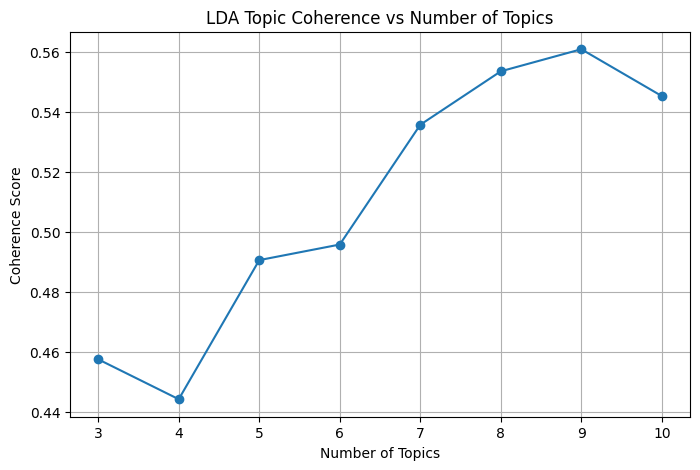

In [49]:
plt.figure(figsize=(8,5))
plt.plot(list(topic_range), coherence_scores, marker='o')
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("LDA Topic Coherence vs Number of Topics")
plt.grid(True)
plt.show()


### Top words per topic

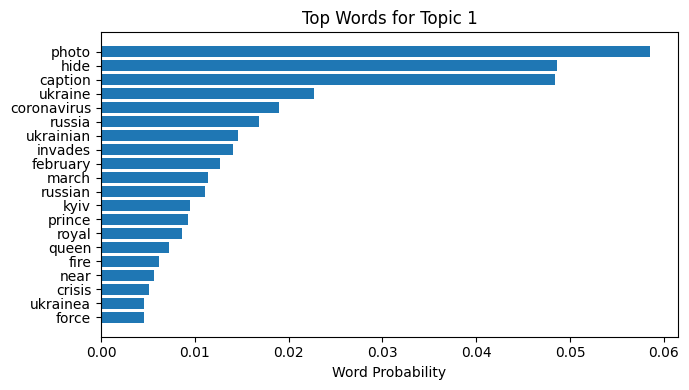

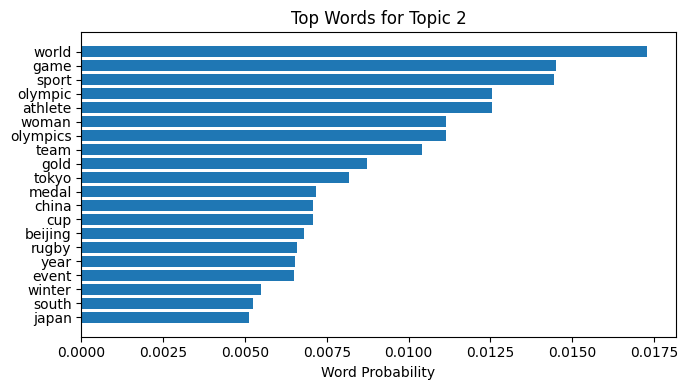

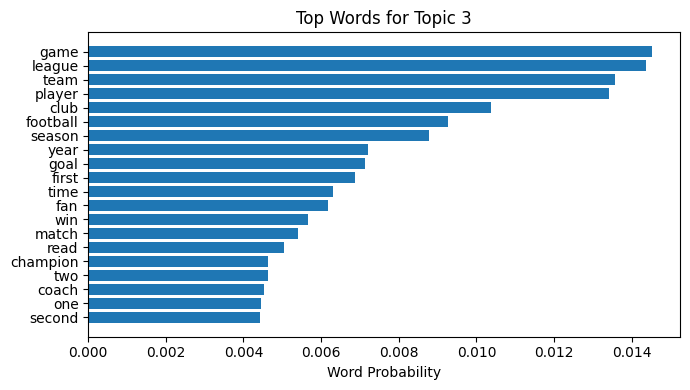

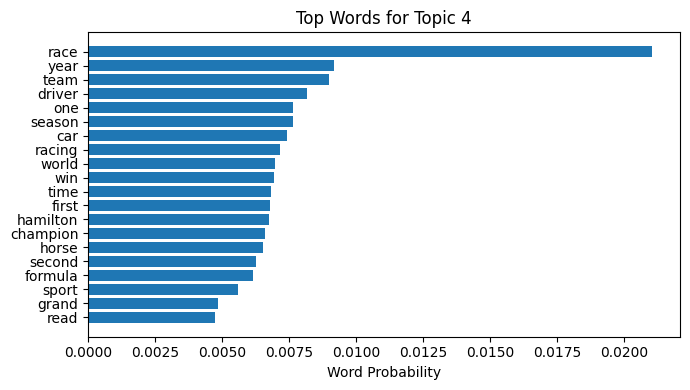

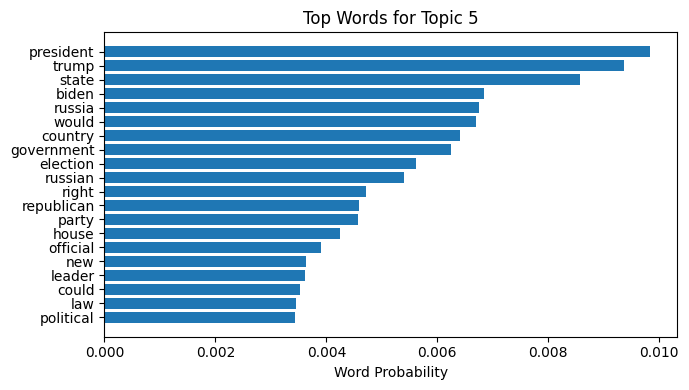

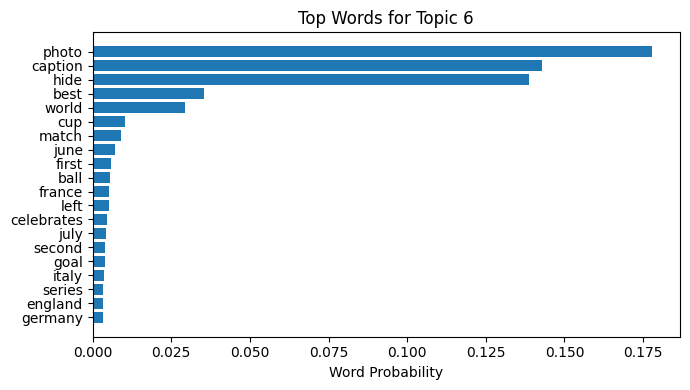

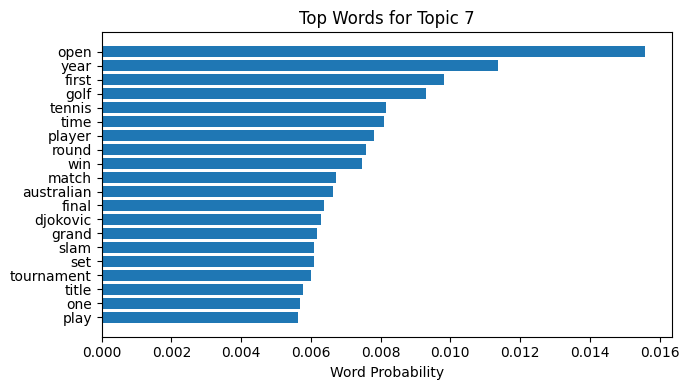

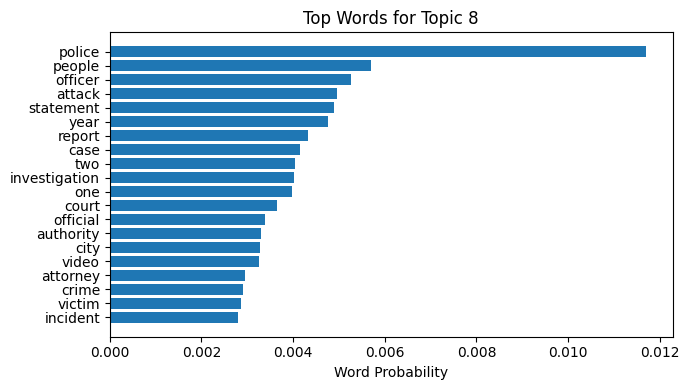

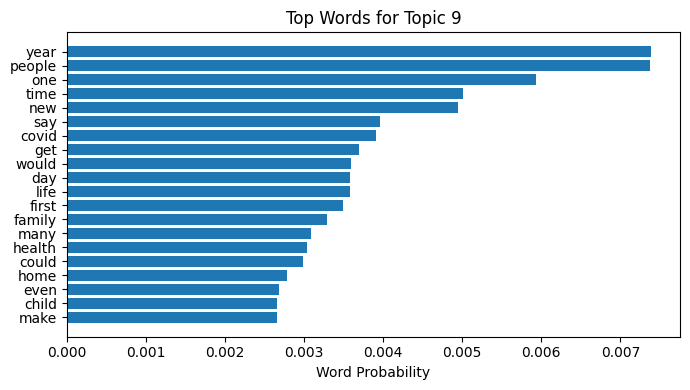

In [110]:
num_words = 20
num_topics = best_k

for topic_id in range(num_topics):

    plt.figure(figsize=(7,4))

    topic_words = lda_model.show_topic(topic_id, topn=num_words)
    words = [w for w, _ in topic_words]
    weights = [v for _, v in topic_words]

    plt.barh(words[::-1], weights[::-1])
    plt.title(f"Top Words for Topic {topic_id+1}")
    plt.xlabel("Word Probability")

    plt.tight_layout()
    plt.show()


### Distribution of dominant topics per article

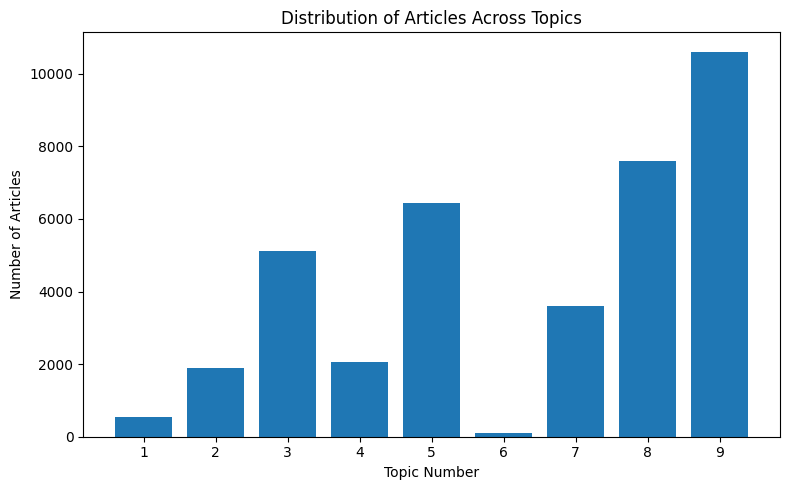

In [88]:
# Get dominant topic for each document
dominant_topics = []

for doc in corpus:
    topics = lda_model.get_document_topics(doc)
    dominant_topic = max(topics, key=lambda x: x[1])[0]
    dominant_topics.append(dominant_topic)

# Count how many documents fall into each topic
topic_counts = [dominant_topics.count(i) for i in range(num_topics)]

# Plot distribution
plt.figure(figsize=(8,5))
plt.bar(range(1, num_topics+1), topic_counts)
plt.xlabel("Topic Number")
plt.ylabel("Number of Articles")
plt.title("Distribution of Articles Across Topics")
plt.xticks(range(1, num_topics+1))
plt.tight_layout()
plt.show()


## Topic Trends

In [92]:
# Compute topic prevalence per year 

years = sorted(df['period'].unique())
prevalence = []

for year in years:
    idx = df[df['period'] == year].index
    year_corpus = [corpus[i] for i in idx]   

    topic_sums = np.zeros(num_topics)

    for bow in year_corpus:
        dist = lda_model.get_document_topics(bow, minimum_probability=0)
        for topic_id, prob in dist:
            topic_sums[topic_id] += prob

    topic_sums /= len(year_corpus)
    prevalence.append(topic_sums)

In [111]:
# Build a clean DataFrame: years x topics

prevalence_df = pd.DataFrame(
    prevalence,
    index=years,
    columns=[f"Topic_{i}" for i in range(num_topics)]
)

prevalence_df

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8
2011,0.006873,0.033107,0.217034,0.077313,0.159702,0.003391,0.173694,0.172568,0.156317
2012,0.015673,0.032468,0.196817,0.078952,0.113870,0.027094,0.193790,0.197494,0.143842
2013,0.025573,0.033681,0.161489,0.077307,0.113500,0.020313,0.180837,0.209832,0.177466
2014,0.092150,0.028572,0.077739,0.052877,0.153685,0.017073,0.149623,0.234062,0.194220
2015,0.024230,0.060288,0.103603,0.060382,0.105974,0.018761,0.080362,0.237376,0.309024
2016,0.020311,0.086741,0.112123,0.063390,0.114585,0.024064,0.087303,0.213937,0.277546
2017,0.019250,0.049198,0.082128,0.069907,0.224581,0.014710,0.074106,0.224214,0.241907
2018,0.019910,0.064832,0.089505,0.062086,0.195294,0.017339,0.065719,0.196806,0.288510
2019,0.016177,0.061559,0.141610,0.057531,0.180950,0.009978,0.060500,0.181088,0.290606
2020,0.025238,0.047823,0.140175,0.034347,0.152469,0.003367,0.061372,0.146533,0.388676


In [109]:
# Print top words for each topic to name them 
print("Topic Keywords:")

for topic_id in range(num_topics):
    words = [word for word, prob in lda_model.show_topic(topic_id, topn=10)]
    print(f"Topic {topic_id}: {', '.join(words)}")

Topic Keywords:
Topic 0: photo, hide, caption, ukraine, coronavirus, russia, ukrainian, invades, february, march
Topic 1: world, game, sport, olympic, athlete, woman, olympics, team, gold, tokyo
Topic 2: game, league, team, player, club, football, season, year, goal, first
Topic 3: race, year, team, driver, one, season, car, racing, world, win
Topic 4: president, trump, state, biden, russia, would, country, government, election, russian
Topic 5: photo, caption, hide, best, world, cup, match, june, first, ball
Topic 6: open, year, first, golf, tennis, time, player, round, win, match
Topic 7: police, people, officer, attack, statement, year, report, case, two, investigation
Topic 8: year, people, one, time, new, say, covid, get, would, day


### Interpreting the top words per topic

In [95]:
topic_names = {
    0: "Russia-Ukraine Conflict",      
    1: "Olympics & International Sports",  
    2: "Professional League Sports",   
    3: "Motorsport & Racing",  
    4: "Politics",   
    5: "Soccer World Cup",   
    6: "Tennis & Golf",
    7: "Crime & Law",
    8: "Global Crises & Health Events" 
}
# Rename prevalence columns
prevalence_df.columns = [topic_names[i] for i in range(num_topics)]

### Topic Evolution (2011-2022)

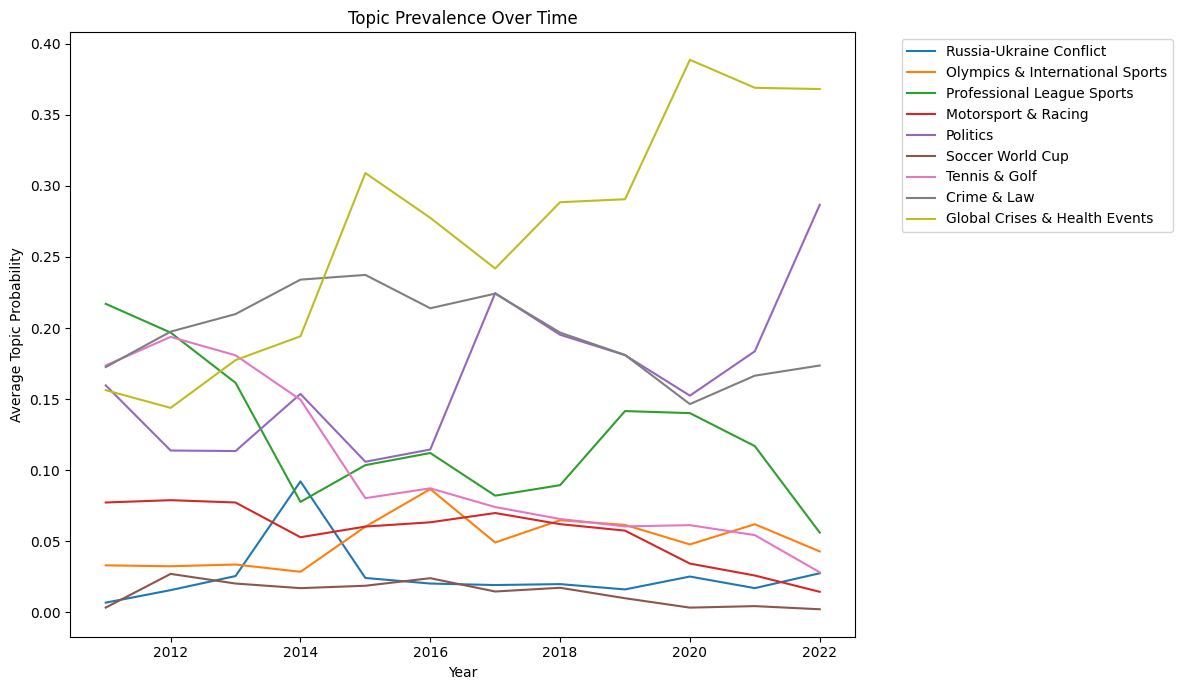

In [98]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,7))

for topic in prevalence_df.columns:
    plt.plot(prevalence_df.index, prevalence_df[topic], label=topic)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Topic Prevalence Over Time")
plt.xlabel("Year")
plt.ylabel("Average Topic Probability")
plt.tight_layout()
plt.show()


### Heatmap of Topic Prevalence

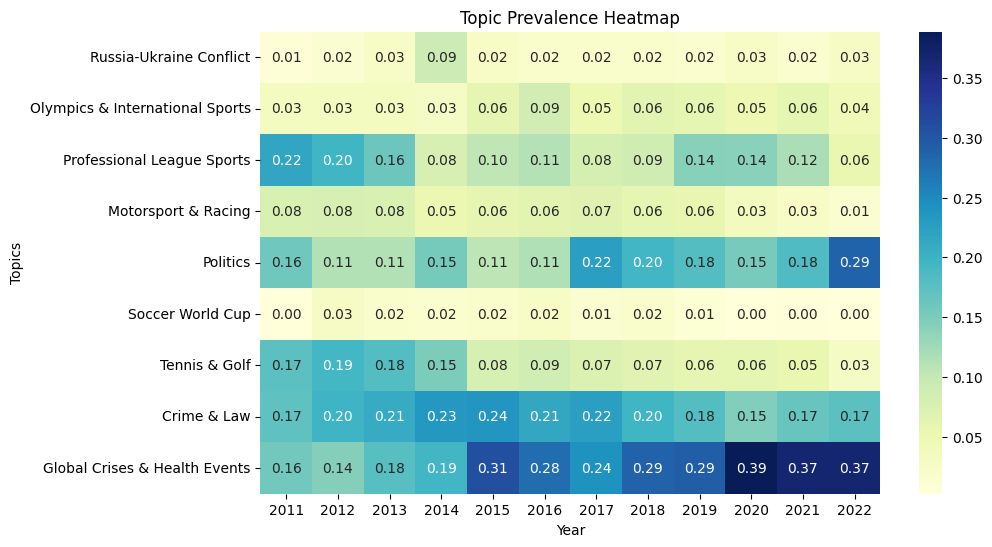

In [ ]:
plt.figure(figsize=(10,6))
sns.heatmap(prevalence_df.T, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Topic Prevalence Heatmap")
plt.ylabel("Topics")
plt.xlabel("Year")
plt.show()


### Cumulative Topic Growth

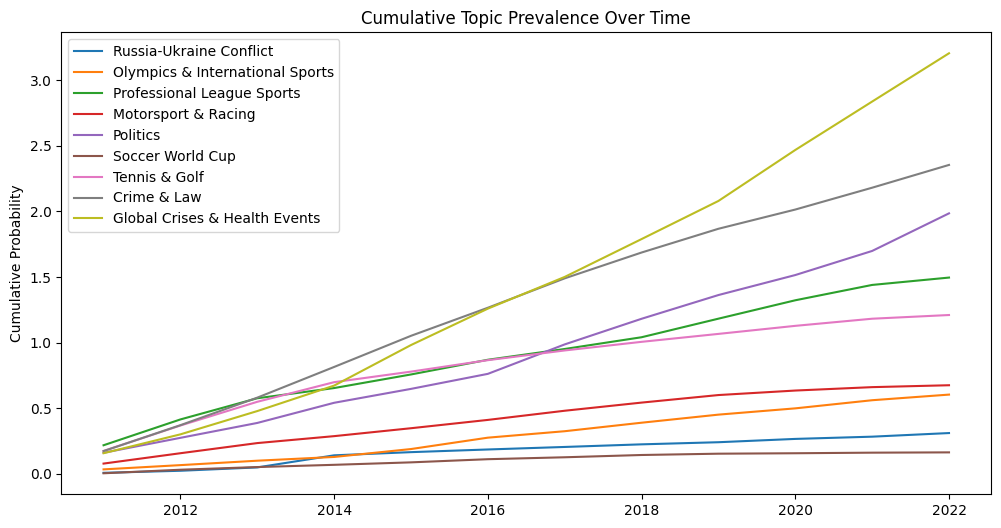

In [104]:
(prevalence_df.cumsum()).plot(figsize=(12,6))
plt.title("Cumulative Topic Prevalence Over Time")
plt.ylabel("Cumulative Probability")
plt.show()
